In [1]:
import parser
import tensorflow as tf
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
chain = parser.Chain('QED')
print(chain)

Chain(3 residues, 47 atoms, 46 bonds)


In [3]:
gradient_multiplier = 0.1
steps = 500

optimizer = tf.optimizers.Adam(learning_rate=gradient_multiplier)

for step in range(steps):
    with tf.GradientTape() as tape:
        energy = chain.get_energy(normalize=True)
        gradient = tape.gradient(energy, chain.get_variables())
    optimizer.apply_gradients([(grad, var) for grad, var in zip(gradient, chain.get_variables()) if grad is not None])
    
    if step % (steps // 10) == 0:
        print(f'Step {step}: {energy.numpy()}')

Step 0: 76.49651336669922
Step 50: 11.477545738220215
Step 100: 1.1224043369293213
Step 150: 0.16581770777702332
Step 200: 0.0806918516755104
Step 250: 0.05314270779490471
Step 300: 0.0355912446975708
Step 350: 0.023614875972270966
Step 400: 0.015493434853851795
Step 450: 0.010028768330812454


<IPython.core.display.Javascript object>


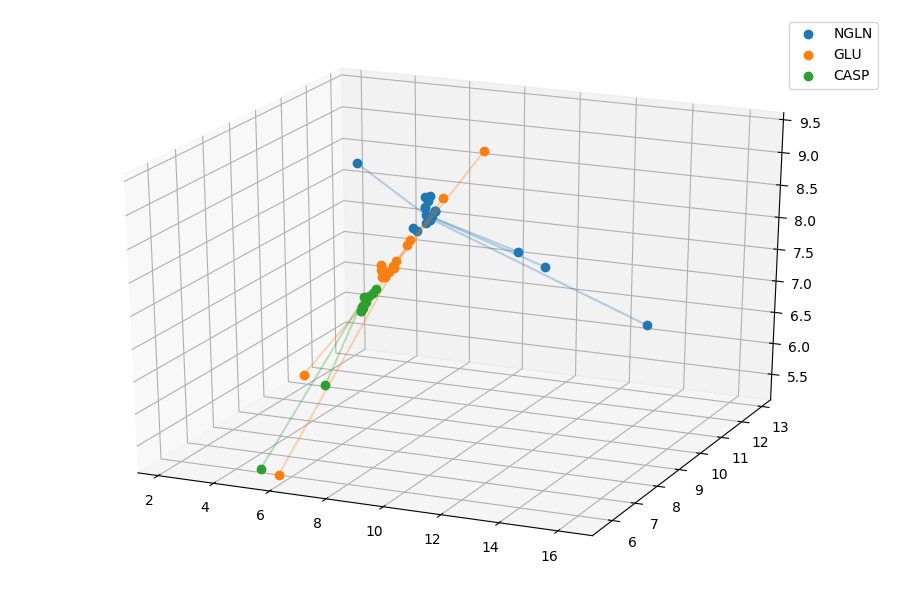

In [4]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

for res in chain.residues:
    pos = np.array([atom.pos.numpy() for atom in res.atoms])
    col = ax.plot(pos[:,0], pos[:,1], pos[:,2], 'o', label=res.name)[0].get_color()

    for bond in res.bonds:
        pos = np.array([bond[0].pos.numpy(), bond[1].pos.numpy()])
        ax.plot(pos[:,0], pos[:,1], pos[:,2], c=col, alpha=0.3)
    
plt.legend()
plt.tight_layout()
plt.show()